In [1]:
import re
import os
import sys
import inspect
import pandas as pd
os.chdir("..")
from src.info_extactor import InfoExtractor
print(os.getcwd())

/home/erezsc/PycharmProjects/geocore


In [2]:
#DATA_PATH = os.path.join("data","test.csv")
DATA_PATH = os.path.join("data","EPI_CoronaExposure_XRM_NEW_31_3_1807_TableToExcel.csv")


df = pd.read_csv(DATA_PATH, index_col=0)
if "מקום" in df.columns.tolist():
    df.rename(columns={"מקום":"place"}, inplace=True)
df_topics = df[["place"]].astype("str")
os.chdir("src")
ie = InfoExtractor()

In [34]:
"percentage of Google extracted location types: {:.2f}".format(len(df["geostatusname"].dropna()) / len(df["geostatusname"]))

'percentage of Google extracted location types: 0.51'

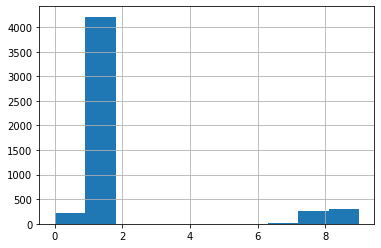

In [28]:
df["valid"].hist(bins=10)

In [32]:
"percentage of Google extracted cities: {:.2f}".format(len(df["CityName"].dropna()) / len(df["CityName"]))

'percentage of Google extracted cities: 0.53'

In [4]:
df_text = df["place"].astype("str")

In [36]:
df_topics["type"] = df_topics["place"].apply(lambda x: None if ie.extract_type(x) is None else ie.extract_type(x)[0])
df_topics["city"] = df_topics["place"].apply(ie.extract_city)
df_topics["city"] = df_topics["city"].apply(lambda x: None if x == '   ' else x)
df_topics["google_type"] = df["geostatusname"]
df_topics["google_city"] = df["CityName"]

In [37]:
df_topics.head()

,place,type,city,google_type,google_city
OBJECTID,,,,,
1,nan,None,None,NaN,NaN
2,nan,None,None,NaN,NaN
3,nan,None,None,NaN,NaN
4,תחנת אוטובוס דיזינגוף/פרישמן תל אביב,None,תל אביב,NaN,NaN
5,תחנת אוטובוס אלנבי (שוק הכרמל) תל אביב,None,תל אביב,NaN,NaN


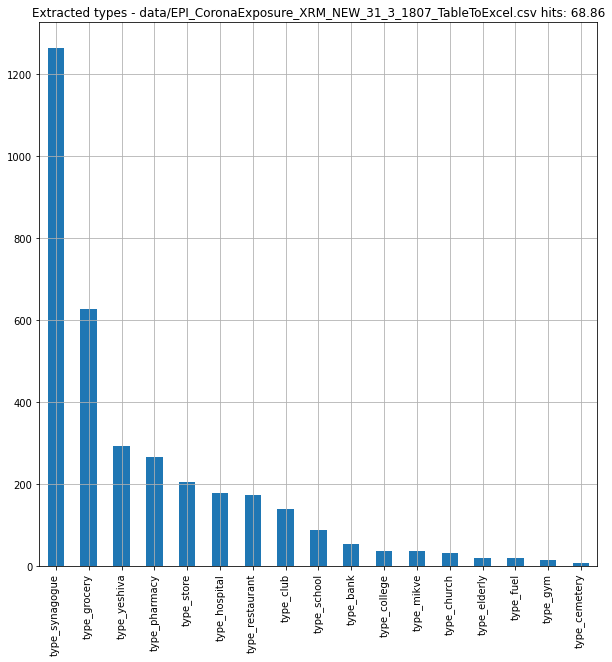

In [7]:
types_agg_df = pd.get_dummies(df_topics[["type"]]).agg("sum").sort_values(ascending=False)
total_extracted_types = types_agg_df.sum()
hit_percentage = "{:.2f}".format(total_extracted_types / len(df_topics) * 100)
types_agg_df.plot.bar(grid=True, figsize=(10,10), title="Extracted types - " + DATA_PATH + " hits: " + hit_percentage)

In [51]:
len(df_topics["city"].dropna()) / len(df_topics["city"])

0.8332666132906325

In [61]:
df_topics[df_topics["city"].notnull()]

,place,type,city,google_type,google_city
OBJECTID,,,,,
4,תחנת אוטובוס דיזינגוף/פרישמן תל אביב,None,תל אביב,NaN,NaN
5,תחנת אוטובוס אלנבי (שוק הכרמל) תל אביב,None,תל אביב,NaN,NaN
7,תחנת רכבת נתניה-ספיר,None,נתניה,NaN,NaN
9,תחנת רכבת באר שבע-מרכז,None,באר שבע,NaN,NaN
10,תחנת רכבת באר שבע-מרכז,None,באר שבע,NaN,NaN
...,...,...,...,...,...
4989,מיון תל השומר - רמת גן,hospital,רמת גן,NaN,רמת גן
4990,חנות מקצועי אלבז - נתניה,store,נתניה,G_Poi,נתניה
4991,"ביה""ח מאיר, מח' יולדות - כפר סבא",hospital,כפר סבא,G_Poi,כפר סבא


In [79]:
print("we miss type and google hits / our misses: {:.2f}".format(len(df_topics[df_topics["type"].isna() & ~df_topics["google_type"].isna()]) / len(df_topics[df_topics["type"].isna()])))
print("we miss city and google hits / our misses: {:.2f}".format(len(df_topics[df_topics["city"].isna() & ~df_topics["google_city"].isna()]) / len(df_topics[df_topics["city"].isna()])))

print("we hit type and google misses / google misses: {:.2f}".format(len(df_topics[~df_topics["type"].isna() & df_topics["google_type"].isna()]) / len(df_topics[df_topics["google_type"].isna()])))
print("we hit city and google misses / google misses: {:.2f}".format(len(df_topics[~df_topics["city"].isna() & df_topics["google_city"].isna()]) / len(df_topics[df_topics["google_city"].isna()])))

print("we miss city and google misses city / total: {:.2f}".format(len(df_topics[~(df_topics["city"].isna() | df_topics["google_city"].isna())]) / len(df_topics)))
print("we miss type and google misses type / total: {:.2f}".format(len(df_topics[~(df_topics["type"].isna() | df_topics["google_type"].isna())]) / len(df_topics)))

we miss type and google hits / our misses: 0.53
we miss city and google hits / our misses: 0.39
we hit type and google misses / google misses: 0.70
we hit city and google misses / google misses: 0.78
we miss city and google misses city / total: 0.47
we miss type and google misses type / total: 0.35


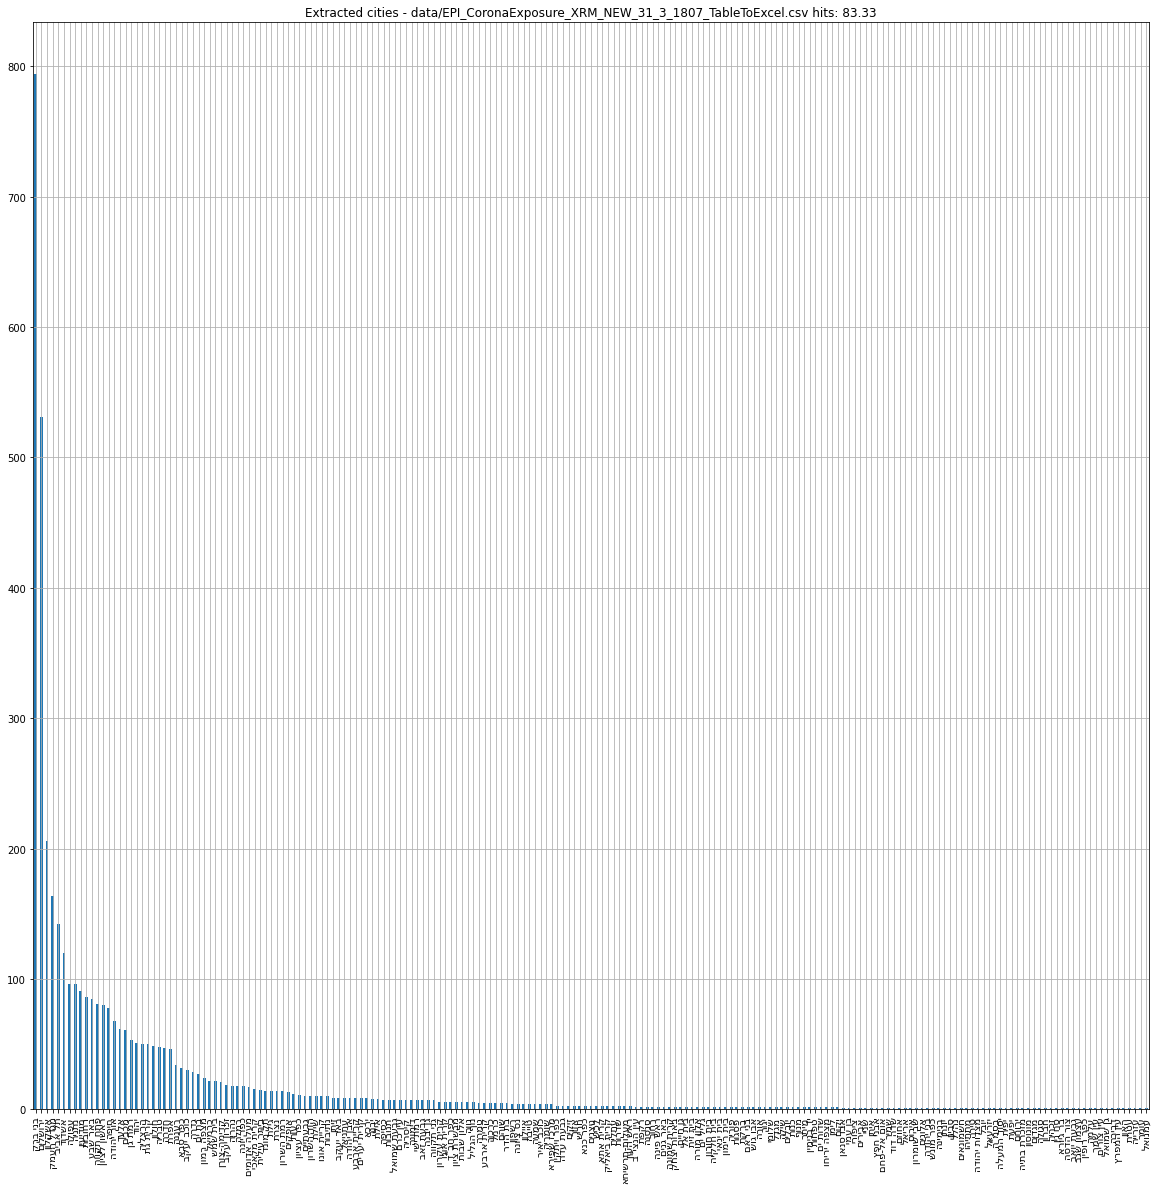

In [9]:
cities_agg_df = pd.get_dummies(df_topics[["city"]]).agg("sum").sort_values(ascending=False)
total_extracted_types = cities_agg_df.sum()
hit_percentage = "{:.2f}".format(total_extracted_types / len(df_topics) * 100)
cities_agg_df.index = pd.Series([x[5:][::-1] for x in cities_agg_df.index.tolist()])
cities_agg_df.plot.bar(grid=True, figsize=(20,20), title="Extracted cities - " + DATA_PATH + " hits: " + hit_percentage)

In [10]:
df_topics[df_topics["city"].isna()].head(100) #failed cities extraction

,place,type,city
OBJECTID,,,
1,nan,None,None
2,nan,None,None
3,nan,None,None
6,תחנת רכבת תל אביב-סבידור מרכז,None,None
8,תחנת רכבת תל אביב-סבידור מרכז,None,None
...,...,...,...
218,קו 59 מאור יהודה (היסמין / החצב) לתל אביב (מנח...,None,None
219,קו 59 מאור יהודה (היסמין / החצב) לתל אביב (מנח...,None,None
220,קו 59 מאור יהודה (היסמין / החצב) לתל אביב (מנח...,None,None


In [11]:
df_topics[df_topics["type"].isna()].head(100)  #failed type extraction

,place,type,city
OBJECTID,,,
1,nan,None,None
2,nan,None,None
3,nan,None,None
4,תחנת אוטובוס דיזינגוף/פרישמן תל אביב,None,תל אביב
5,תחנת אוטובוס אלנבי (שוק הכרמל) תל אביב,None,תל אביב
...,...,...,...
147,קו 59 מאור יהודה (היסמין / החצב) לתל אביב (מנח...,None,None
148,קו 59 מאור יהודה (היסמין / החצב) לתל אביב (מנח...,None,None
149,קו 59 מאור יהודה (היסמין / החצב) לתל אביב (מנח...,None,None
